# train and validate the model

In [1]:
# math
import pandas as pd 
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

# models 

# evaluation of models 
from sklearn.metrics import confusion_matrix
from sklearn import cross_validation, metrics



In [2]:
# import data from scores table
# import data from signal table
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

dbname = 'urx'
username = 'noahburbank'
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))

In [3]:
# import worker data 
# connect:
con = None
con = psycopg2.connect(database = dbname, user = username)

# query:
sql_query = """
SELECT * FROM signals_exp2;
"""
signals = pd.read_sql_query(sql_query,con)

print "signal columns are: "
print signals.columns

signal columns are: 
Index([u'index', u'_unit_id', u'title_sim', u'body_sim', u'meta_sim',
       u'one_grams', u'two_grams', u'three_grams', u'meta_one_gram',
       u'meta_two_gram', u'meta_three_gram', u'starturl', u'endurl',
       u'start_domain', u'end_domain', u'body_lcf_score', u'title_lcf_score',
       u'desc_lcf_score', u'body_ner_cosine', u'title_ner_cosine',
       u'desc_ner_cosine', u'body_ner_intersection', u'title_ner_intersection',
       u'desc_ner_intersectipon', u'score', u'majority'],
      dtype='object')


### import all data, put into df, manipulate for modeling

In [5]:
# make into single dataframe
model_df = pd.DataFrame()
model_df['score'] = signals['majority']
                           
#tfidf information
model_df['title_sim'] = signals['title_sim']
model_df['meta_sim'] = signals['meta_sim']
model_df['body_sim'] = signals['body_sim']

# ngram inforation on titles
model_df['one_gram'] = signals['one_grams']#
model_df['two_gram'] = signals['two_grams']
model_df['three_gram'] = signals['three_grams']

# lcf scores
model_df['body_lcf_score'] = signals['body_lcf_score']
model_df['title_lcf_score'] = signals['title_lcf_score']
model_df['desc_lcf_score'] = signals['desc_lcf_score']

# ngram for description
model_df['meta_one_gram'] = signals['meta_one_gram']
model_df['meta_two_gram'] = signals['meta_two_gram']
model_df['meta_three_gram'] = signals['meta_three_gram']

# ner cosine scores
model_df['body_ner_cosine'] = signals['body_ner_cosine']
model_df['title_ner_cosine'] = signals['title_ner_cosine']
model_df['desc_ner_cosine'] = signals['desc_ner_cosine']

# ner cosine scores
model_df['body_ner_intersection'] = signals['body_ner_intersection']
model_df['title_ner_intersection'] = signals['title_ner_intersection']
model_df['desc_ner_intersection'] = signals['desc_ner_intersectipon']

In [6]:
# split into training and testing sets 
np.random.seed(2)
msk = np.random.rand(len(signals)) < 0.6

train = model_df[msk]
test = model_df[~msk]

In [7]:
X = train.ix[:, train.columns != 'score']
Y = train.ix[:, train.columns == 'score']

### create and train the models

In [8]:
# create models 
from sklearn.ensemble import RandomForestClassifier
clf = RandomForestClassifier(n_estimators=100, random_state = 5, max_features = 5)

from sklearn.linear_model import LogisticRegression
linreg = LogisticRegression()

from sklearn import tree
tree = tree.DecisionTreeClassifier(max_depth = 4)

from sklearn.ensemble import AdaBoostClassifier
boost = AdaBoostClassifier()

from sklearn.ensemble import GradientBoostingClassifier
gradient = GradientBoostingClassifier()

from sklearn import svm
svm_model = svm.SVC(probability=True)

from sklearn.naive_bayes import BernoulliNB
bernouli_nb = BernoulliNB()

from sklearn.naive_bayes import GaussianNB
gnb = GaussianNB().fit(X,Y)


# train models

clf = clf.fit(X,Y)
linreg = linreg.fit(X,Y)
tree = tree.fit(X,Y)
boost = boost.fit(X,Y)
gradient = gradient.fit(X,Y)
svm_model = svm_model.fit(X,Y)
bernouli_nb = bernouli_nb.fit(X,Y)
gnb = gnb.fit(X,Y)



# models into a list
models = [clf, linreg, tree, boost, gradient, svm_model, bernouli_nb, gnb]

/Users/noahburbank/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/noahburbank/anaconda/envs/py2/lib/python2.7/site-packages/ipykernel/__main__.py:29: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/Users/noahburbank/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/noahburbank/anaconda/envs/py2/lib/python2.7/site-packages/sklearn/utils/validation.py:449: DataConversionWarning: A column-vector y was passed when a 1d array was expected. 

### evaluate the performance of the models
1. residuals and rms
2. confusion matrix, accuracy, precision, recall, and f1
3. cross validation
4. auc 
5. auc graph with multiple models 

In [9]:
def evaluate_model(model):
#    print "for " + str(model)
#    print
    # get predicted, predicted prob, and actual values
    predicted = model.predict(test.ix[:, train.columns != 'score'])
    predicted_proba = model.predict_proba(test.ix[:, train.columns != 'score'])
    actual = test['score']

    # evaluate based on residuals 
    residuals = predicted - actual
#    print 'sum of residuals: ' + str(np.sum(residuals))
    rms = pd.Series(data = residuals).apply(lambda x: x**2).sum()
#    print 'rms: ' + str(rms)
    
    # evaluate based on confusion matrix 
    cm = confusion_matrix(actual, predicted)
    a = float(cm[0,0])
    b = float(cm[0,1])
    c = float(cm[1,0])
    d = float(cm[1,1])

    # calculate cm measures 
    try: 
        precision = d / (d + b)
    except ZeroDivisionError:
        precision = "not an answerable question"

    recall =  d / (c + d)
    accuracy = (a + d)/ (a + b + c + d)
    f1 = 2*(precision * recall)/ (precision+recall)

#    print 
#    print 'accuracy is ' + str(round(accuracy,3))
#    print "precision is " + str(round(precision,3)) + " (how many called relevant links are actually relevant)"
#    print "recall is " + str(round(recall,3)) + " (how many relevant links it actually called relevant)"
#    print "f1 is " + str(round(f1,3))
#    print 

    # cross validation
    
    # this requires me to change the shape of Y so that it's (len,) instead of (len,1)
    Y1 = np.asarray(Y).ravel()

    fold_count = 10
    # cv = 'cross-validations' = 'no. of k-foldings to do' in the language I used above
    scores_train = cross_validation.cross_val_score(model, X, Y1, cv=fold_count)
    # With 68% CLs on the accuracy
#    print "for " + str(fold_count) + " folds"
#    print 'Average accuracy on cross-validated training set: %0.3f ± %0.3f' % (scores_train.mean(),scores_train.std())
    
    
    # auc calculation
    fpr, tpr, thresholds = metrics.roc_curve(actual, (1-predicted_proba[:,1]), pos_label = 1)
    roc_auc = metrics.auc(fpr,tpr)
#    print 
#    print "the area under the curve is: " + str(round(roc_auc,3))
#    print
#    print 
#    print
#    print
    return [rms, round(scores_train.mean(),3), round(accuracy,3), round(precision,3), round(recall, 3), round(f1, 3), round(roc_auc,3)]

In [10]:
# create data frame for evaluating models 
column_names = ['RMS', 'CV Acc', 'OOB Acc', 'Precision', 'Recall', 'F1', 'AUC']
model_eval_df = pd.DataFrame(columns = ['RMS', 'CV Acc', 'OOB Acc', 'Precision', 'Recall', 'F1', 'AUC'])

# put them all in a dataframe 
for model in models:
    temp_df = pd.DataFrame(evaluate_model(model),column_names).T
    temp_df.index = [str(type(model)).split('.')[-1].replace('>', '').replace('\'', '')]
    model_eval_df = model_eval_df.append(temp_df)
    

# output
model_eval_df

,RMS,CV Acc,OOB Acc,Precision,Recall,F1,AUC
RandomForestClassifier,88,0.817,0.932,0.893,0.852,0.872,0.973
LogisticRegression,212,0.830,0.836,0.754,0.591,0.662,0.906
DecisionTreeClassifier,168,0.780,0.870,0.756,0.773,0.764,0.925
AdaBoostClassifier,140,0.810,0.892,0.805,0.795,0.800,0.936
GradientBoostingClassifier,104,0.810,0.920,0.860,0.841,0.851,0.966
SVC,292,0.804,0.775,0.597,0.523,0.558,0.867
BernoulliNB,272,0.801,0.790,0.661,0.466,0.547,0.795
GaussianNB,188,0.816,0.855,0.815,0.602,0.693,0.901


#### roc curve graphs

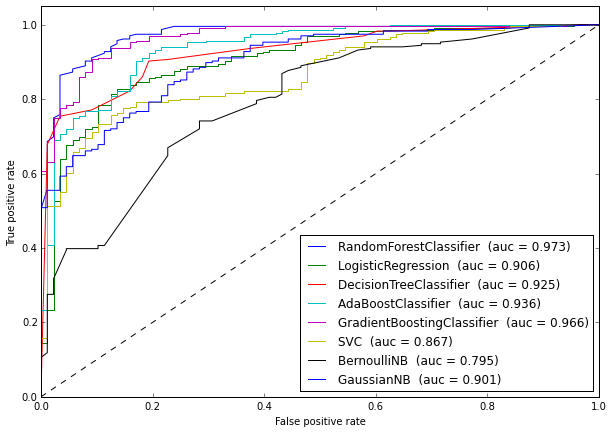

In [11]:
# create the plot
f, a = plt.subplots()
f.set_size_inches(10,7)

# create curve for each model 
indexer = range(0,len(models))
for index in indexer: 
    name = str(type(models[index])).split('.')[-1].replace('>', '').replace('\'', '')
    
    model = models[index]
    actual = test['score']
    predicted_proba = model.predict_proba(test.ix[:, train.columns != 'score'])
    
    # generate the names for each model
    fpr_name = 'fpr_' + str(index)
    tpr_name = 'tpr_' + str(index)
    roc_auc_name = 'roc_auc_' + str(index)
    
    # calculate the roc curve contents, and auc 
    fpr_name, tpr_name, thresholds = metrics.roc_curve(actual, (1-predicted_proba[:,1]), pos_label = 1)
    roc_auc_name = metrics.auc(fpr_name,tpr_name)

    # generate the plot object 
    a.plot(fpr_name, tpr_name, label = name + '  (auc = %0.3f)' % roc_auc_name)


# The 50/50 fpr/tpr line
a.plot([0,1],[0,1],'k--') #, label='Random chance predictor')
a.set_xlim(0.0,1.0)
a.set_ylim(0.0,1.05)
a.set_xlabel('False positive rate')
a.set_ylabel('True positive rate')
a.legend(loc='lower right')

#### show the importance of different features

In [12]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]

# Print the feature ranking
print("Feature ranking:")

for f in range(X.shape[1]):
    print("%d. feature %d (%f)" % (f + 1, indices[f], importances[indices[f]])), model_df.columns[f+1]
    

Feature ranking:
1. feature 0 (0.259214) title_sim
2. feature 2 (0.135453) meta_sim
3. feature 5 (0.117125) body_sim
4. feature 9 (0.067588) one_gram
5. feature 10 (0.066359) two_gram
6. feature 4 (0.064879) three_gram
7. feature 3 (0.064679) body_lcf_score
8. feature 7 (0.061136) title_lcf_score
9. feature 1 (0.053948) desc_lcf_score
10. feature 11 (0.047221) meta_one_gram
11. feature 15 (0.018617) meta_two_gram
12. feature 8 (0.012810) meta_three_gram
13. feature 12 (0.011980) body_ner_cosine
14. feature 6 (0.011664) title_ner_cosine
15. feature 13 (0.004711) desc_ner_cosine
16. feature 16 (0.002616) body_ner_intersection
17. feature 14 (0.000000) title_ner_intersection
18. feature 17 (0.000000) desc_ner_intersection


# compare the between domain accuracy scores

In [102]:
indexer = range(0,1000)
list_of_f1_scores = []
list_of_irrelevant_percent = []
list_of_p_values = []

for index in indexer: 
    if index == 109:
        continue
    
# split into training and testing sets 
    np.random.seed(index)
    msk = np.random.rand(len(signals)) < 0.6

    train = model_df[msk]
    test = model_df[~msk]

    domain_df = model_df
    domain_df['start_domain'] = signals.start_domain
    domain_df['end_domain'] = signals.end_domain

    training_domain_df = domain_df
    domain_df = domain_df[~msk]

    domain_auc_dict = {}
    domain_f1_dict = {}
    domain_length_dict = {}
    accuracy_dict = {}
    precision_dict = {}
    recall_dict = {}

    for domain in domain_df.groupby('start_domain'):
        x,y = domain[1].shape
        domain_length_dict[domain[0]] = x
        features = domain_df[domain_df['start_domain'] == domain[0]]
        actual = features[features['start_domain'] == domain[0]].score
        features = features.ix[:, domain_df.columns != 'score']
        features = features.ix[:, features.columns != 'start_domain']
        features = features.ix[:, features.columns != 'end_domain']
        proba_predictions = clf.predict_proba(features)
        fpr_rf, tpr_rf, thresholds = metrics.roc_curve(actual, (1-proba_predictions[:,1]), pos_label = 1)
        predictions = clf.predict(features)
        f1_score = metrics.f1_score(actual,predictions)
        domain_f1_dict[domain[0]] = f1_score
        roc_auc_rf = metrics.auc(fpr_rf,tpr_rf)
        domain_auc_dict[domain[0]] = roc_auc_rf
        accuracy = metrics.accuracy_score(actual,predictions)
        accuracy_dict[domain[0]] = accuracy
        cm = confusion_matrix(actual, clf.predict(features))
        precision = metrics.precision_score(actual,predictions)
        precision_dict[domain[0]] = precision
        recall = metrics.recall_score(actual,predictions)
        recall_dict[domain[0]] = recall

    # make a df
    domain_validation = pd.DataFrame()
    domain_validation['domain'] = domain_auc_dict.keys()
    domain_validation['auc'] = domain_auc_dict.values()
    domain_validation['f1'] = domain_f1_dict.values()
    domain_validation['length'] = domain_length_dict.values()
    domain_validation['accuracy'] = accuracy_dict.values()
    domain_validation['precision'] = precision_dict.values()
    domain_validation['recall'] = recall_dict.values()
    
    #get the initial distribution of relevant/irrelevant and compare with the global percent irrelevant (not the ratio)

    global_irrelevant_percent = list(model_df.score.value_counts())[0]/ (0. + len(model_df))

    start_domain_irrelevant_percent = {}

    for start_domain in model_df.groupby('start_domain'):
        name = start_domain[0]
        rels = list(start_domain[1].score.value_counts())

        irrelevant = rels[0]
        if len(rels) == 1:
            relevant = 0

        else:
            relevant = rels[1]

        percent_irrelevant = irrelevant/(irrelevant + relevant + 0.)

        start_domain_irrelevant_percent[name] = percent_irrelevant
    ordered_list = []
    for domain in domain_validation.domain:
        ordered_list.append(start_domain_irrelevant_percent[domain])
    domain_validation['irrelevant_percent'] = ordered_list
    list_of_f1_scores.append(domain_validation.f1)
    list_of_irrelevant_percent.append(domain_validation.irrelevant_percent)
    
    
    point_list = np.linspace(.5, 1, 50)
    optimal_break = {}
    for break_point in point_list:
        under_73 = domain_validation[domain_validation.irrelevant_percent < break_point].f1
        over_73 = domain_validation[domain_validation.irrelevant_percent > break_point].f1
        over_73 = over_73.dropna()
        optimal_break[break_point] = ttest_ind(under_73, over_73).pvalue
    list_of_p_values.append(optimal_break.values())
    print index 

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
100
101
102
103
104
105
106
107
108
110
111
112
113
114
115
116
117
118
119
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
180
181
182
183
184
185
186
187
188
189
190
191
192
193
194
195
196
197
198
199


ValueError: At least 2 points are needed to compute area under curve, but x.shape = 1

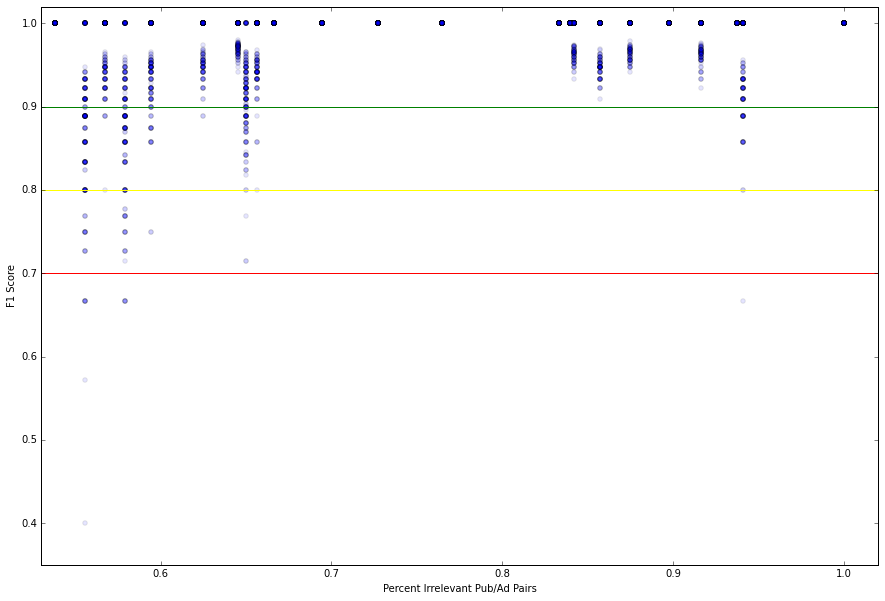

In [125]:
list_of_f1_scores
plt.figure(figsize=(15,10))
plt.scatter([item for sublist in list_of_irrelevant_percent for item in sublist],[item for sublist in list_of_f1_scores for item in sublist],alpha = .1)
plt.xlim(.53,1.02)
plt.ylim(.35, 1.02)
plt.xlabel('Percent Irrelevant Pub/Ad Pairs')
plt.ylabel('F1 Score')
plt.axhline(.9, color = 'green')
plt.axhline(.8, color = 'yellow')
plt.axhline(.7, color = 'red')


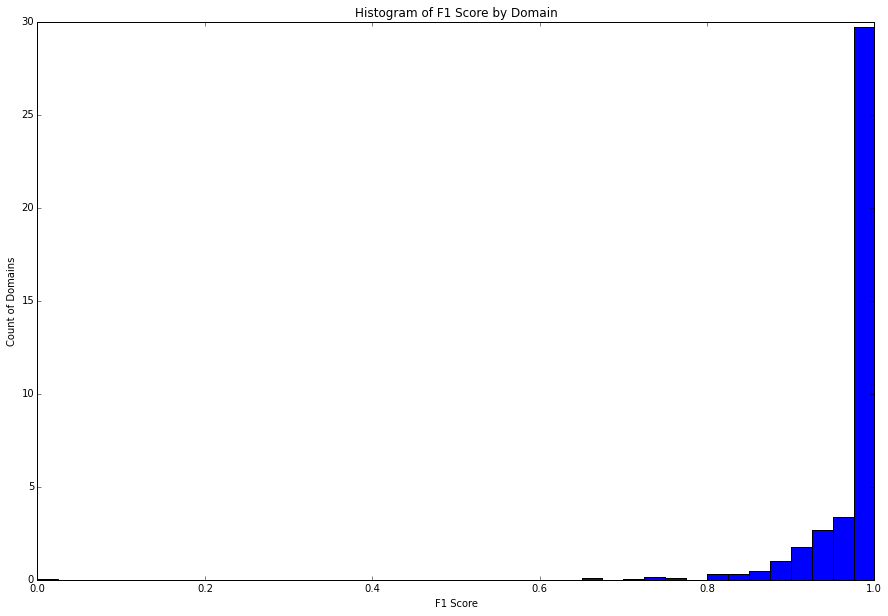

In [122]:
plt.figure(figsize=(15,10))

plt.hist([item for sublist in list_of_f1_scores for item in sublist], bins = 40, normed = True)
plt.ylabel('Count of Domains')
plt.xlabel('F1 Score')
plt.title('Histogram of F1 Score by Domain')

ValueError: x and y must be the same size

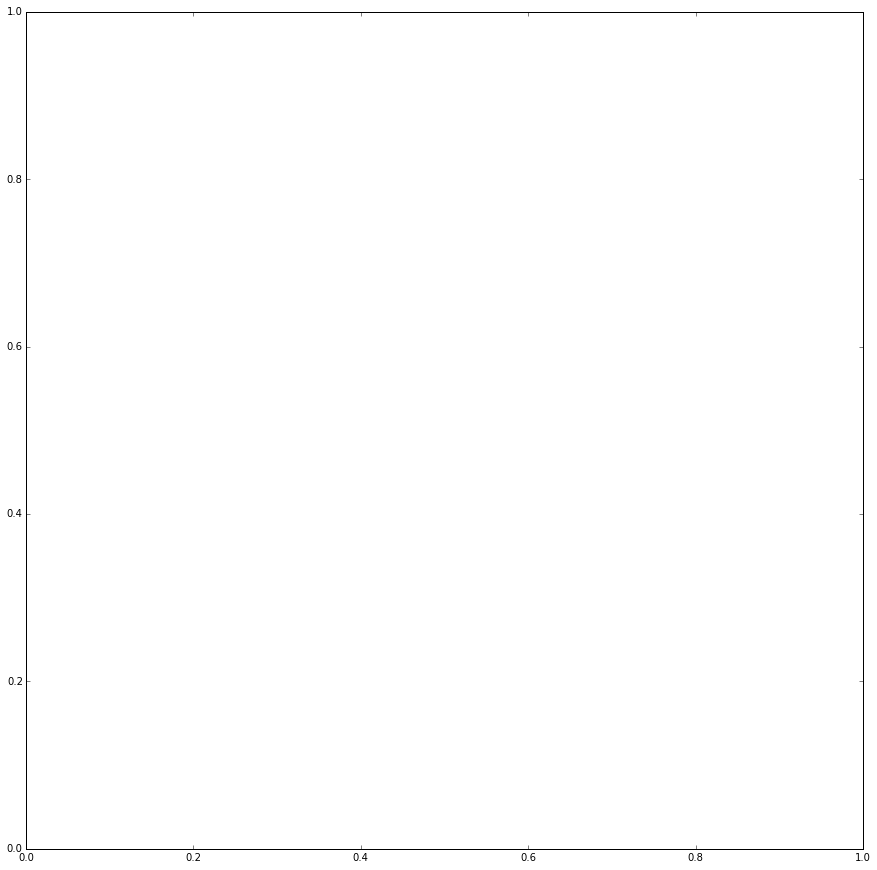

In [108]:
plt.figure(figsize=(15,15))

plt.scatter([item for sublist in [breaks_df.break_point] * 100 for item in sublist],[item for sublist in list_of_p_values for item in sublist], alpha = .01)
plt.axhline(.05)
plt.axvline(global_irrelevant_percent)
plt.ylabel('P-Value')
plt.xlabel('Cutoff')
plt.title('Cutoff vs. P-Value')



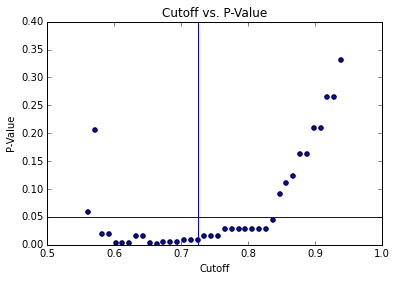

In [110]:
breaks_df = pd.DataFrame()
breaks_df['break_point'] = optimal_break.keys()
breaks_df['p_value'] = optimal_break.values()
plt.figure(figsize=(15,15))

breaks_df.plot(kind = 'scatter' , x = 'break_point', y = 'p_value', xlim = (.5, 1), ylim = (0,.4))
plt.axhline(.05)
plt.axvline(global_irrelevant_percent)
plt.ylabel('P-Value')
plt.xlabel('Cutoff')
plt.title('Cutoff vs. P-Value')

In [113]:
total_count = len(np.array([item for sublist in list_of_f1_scores for item in sublist]))

In [123]:
thresh_count = sum(np.array([item for sublist in list_of_f1_scores for item in sublist])> .95)

In [124]:
(thresh_count + 0.)/total_count

0.82759953614224968

In [655]:
# generation addiitonal features from the original data related to the domain, it's coverage in the training set,
# and the initial ratio between relevant/irrelevant
domain_training_length = {}

for domain in  training_domain_df[~msk].groupby('start_domain'):
    domain_training_length[domain[0]] = len(domain[1])

ordered_training_list = []
for domain in domain_validation['domain']:
    ordered_training_list.append(domain_training_length[domain])
    
domain_validation['training_length'] = ordered_training_list

full_train_df = model_df[msk]

relevance_ratio = {}

for domain_scores in full_train_df.groupby('start_domain').score:
    name =  domain_scores[0]
    ratio = list(domain_scores[1].value_counts())
    if len(ratio) == 2:
        initial_ratio = (ratio[0] + 0.)/(ratio[0] + ratio[1])
    else:
        initial_ratio = 1
    relevance_ratio[name] = initial_ratio
    
ordered_list = []
for domain in domain_validation.domain:
    ordered_list.append(relevance_ratio[domain])
    
domain_validation['testing_ratio'] = ordered_list

0.964966893042
0.0658676588607


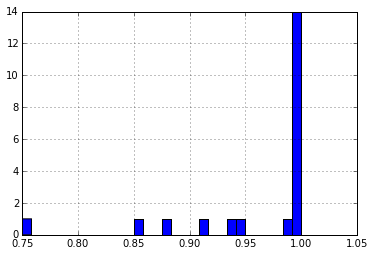

In [656]:
domain_validation.auc.hist(bins = 30)
print domain_validation.auc.mean()
print domain_validation.auc.std()

0.931517527913
0.133556261286


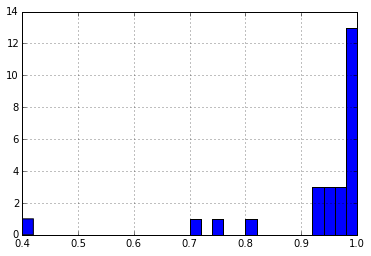

In [657]:
domain_validation.f1.hist(bins = 30)
print domain_validation.f1.mean()
print domain_validation.f1.std()

0.934005453236
0.0910389135729


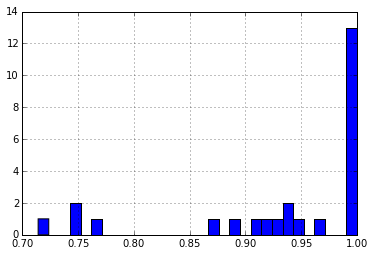

In [658]:
domain_validation.accuracy.hist(bins = 30)
print domain_validation.accuracy.mean()
print domain_validation.accuracy.std()

### deal with and explain those stupid outliers

In [47]:
# this is the standard import if you're using "formula notation" (similar to R)
import statsmodels.formula.api as smf

# create a fitted model in one line
lm = smf.ols(formula='f1 ~ testing_ratio', data=domain_validation).fit()

# print the coefficients
print lm.summary()

X_prime = np.linspace(domain_validation.testing_ratio.min(), domain_validation.testing_ratio.max(), 26)
Y_prime = (X_prime * .309) + .6879
plt.scatter(domain_validation.testing_ratio, domain_validation.f1, alpha=0.3)  # Plot the raw data
plt.plot(X_prime, Y_prime, 'r', alpha=0.9)  # Add the regression line, colored in red

NameError: name 'testing_ratio' is not defined

In [660]:
training_ratio = {}
for domain in model_df[~msk].groupby('start_domain'):
    name = domain[0]
    ratio = list(domain[1].score.value_counts())
    if len(ratio) == 2:
        initial_ratio = (ratio[0] + 0.)/(ratio[0] + ratio[1])
    else:
        initial_ratio = 1
    training_ratio[name] = initial_ratio


ordered_list = []
for domain in domain_validation.domain:
    ordered_list.append(training_ratio[domain])

domain_validation['training_ratio'] = ordered_list

In [661]:
#global porportion
vc_list = list(model_df.score.value_counts())
global_proportion = vc_list[0] / (0. + vc_list[0] + vc_list[1])

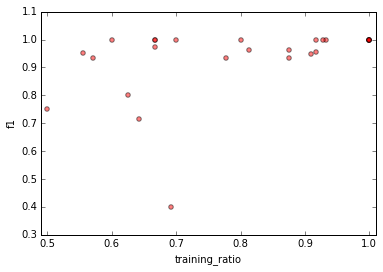

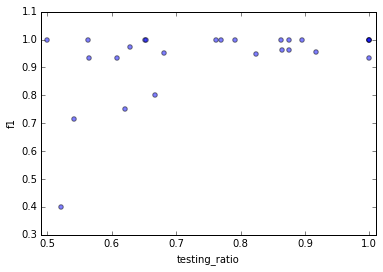

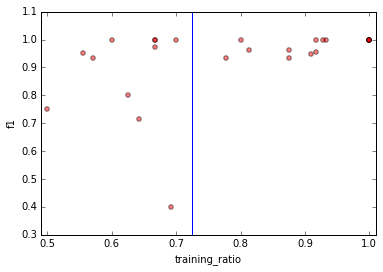

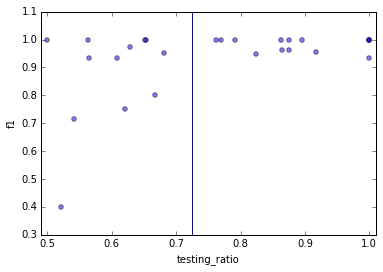

In [662]:
domain_validation.plot(kind = 'scatter', x = 'training_ratio', y = 'f1', color = 'red', xlim = (0.49,1.01), alpha = .5)

domain_validation.plot(kind = 'scatter', x = 'testing_ratio', y = 'f1', color = 'blue', xlim=(0.49,1.01), alpha = .5)

domain_validation.plot(kind = 'scatter', x = 'training_ratio', y = 'f1', color = 'red', xlim = (0.49,1.01), alpha = .5)
plt.axvline(global_proportion)

domain_validation.plot(kind = 'scatter', x = 'testing_ratio', y = 'f1', color = 'blue', xlim=(0.49,1.01), alpha = .5)
plt.axvline(global_proportion)

In [46]:
under_73 = domain_validation[domain_validation.testing_ratio < global_proportion].f1
over_73 = domain_validation[domain_validation.testing_ratio > global_proportion].f1
over_73 = over_73.dropna()

print stats.ttest_ind(under_73, over_73)
print len(under_73)
print len(over_73)

AttributeError: 'DataFrame' object has no attribute 'testing_ratio'

In [664]:
domain_validation[domain_validation.f1 < .9]

,domain,auc,f1,length,accuracy,precision,recall,training_length,testing_ratio,training_ratio
9,songlyrics,1.000000,0.400000,13,0.769231,1.000000,0.25,13,0.521739,0.692308
14,blabbermouth,0.933333,0.714286,14,0.714286,0.555556,1.00,14,0.541667,0.642857
17,cinemablend,0.750000,0.750000,8,0.750000,0.750000,0.75,8,0.620690,0.500000
21,directlyrics,0.883333,0.800000,16,0.750000,0.800000,0.80,16,0.666667,0.625000


### the basic take away here is that the closer your training ratio is to .5, the worse off you are. this makes sense, becuase you're looking at a more and more challening and uninformative prior. 

### the tricky part of this is that you can improve this by training it against more irrelevant websites. It would seem like you would need to add more cases of relevance to teach it that, but it would appear that adding more irrelevant options should do the case. 

In [ ]:
list_of_f1_scores.append(domain_validation.f1)
list_of_testing_ratios.append(domain_validation.testing_ratio)

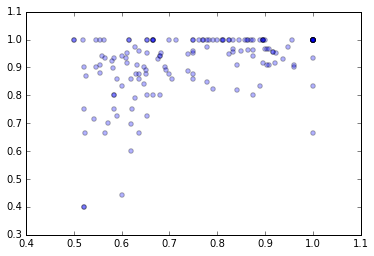

In [672]:
plt.scatter([item for sublist in list_of_testing_ratios for item in sublist],[item for sublist in list_of_f1_scores for item in sublist],alpha = .3)

(array([  2.,   0.,   1.,   0.,   0.,   0.,   0.,   0.,   0.,   1.,   0.,
          0.,   0.,   4.,   1.,   2.,   2.,   3.,   0.,   2.,   6.,   4.,
          7.,   6.,   5.,  14.,   7.,  15.,  12.,  62.]),
 array([ 0.4 ,  0.42,  0.44,  0.46,  0.48,  0.5 ,  0.52,  0.54,  0.56,
         0.58,  0.6 ,  0.62,  0.64,  0.66,  0.68,  0.7 ,  0.72,  0.74,
         0.76,  0.78,  0.8 ,  0.82,  0.84,  0.86,  0.88,  0.9 ,  0.92,
         0.94,  0.96,  0.98,  1.  ]),
 <a list of 30 Patch objects>)

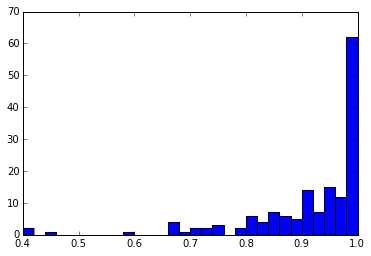

In [674]:
plt.hist([item for sublist in list_of_f1_scores for item in sublist], bins = 30)

Ttest_indResult(statistic=-2.301998916991514, pvalue=0.030318965711428104)
12
14


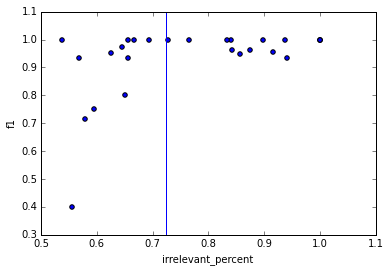

In [719]:
domain_validation.plot(kind = 'scatter', x = 'irrelevant_percent', y = 'f1')
plt.axvline(global_irrelevant_percent)

under_73 = domain_validation[domain_validation.irrelevant_percent < global_proportion].f1
over_73 = domain_validation[domain_validation.irrelevant_percent > global_proportion].f1
over_73 = over_73.dropna()

print stats.ttest_ind(under_73, over_73)
print len(under_73)
print len(over_73)


In [61]:
from scipy.stats import ttest_ind

point_list = np.linspace(.5, 1, 50)
optimal_break = {}
for break_point in point_list:
    under_73 = domain_validation[domain_validation.irrelevant_percent < break_point].f1
    over_73 = domain_validation[domain_validation.irrelevant_percent > break_point].f1
    over_73 = over_73.dropna()
    optimal_break[break_point] = ttest_ind(under_73, over_73).pvalue

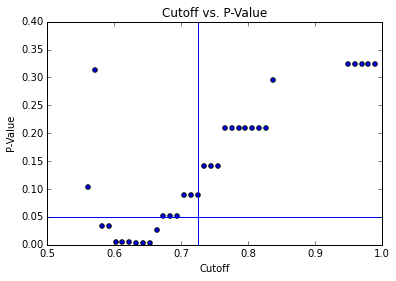

In [62]:
breaks_df = pd.DataFrame()
breaks_df['break_point'] = optimal_break.keys()
breaks_df['p_value'] = optimal_break.values()
breaks_df.plot(kind = 'scatter' , x = 'break_point', y = 'p_value', xlim = (.5, 1), ylim = (0,.4))
plt.axhline(.05)
plt.axvline(global_irrelevant_percent)
plt.ylabel('P-Value')
plt.xlabel('Cutoff')
plt.title('Cutoff vs. P-Value')


In [732]:
len(domain_validation)

26